## Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from flask import Flask, render_template, request, jsonify, send_from_directory
from keras.models import load_model
from keras.models import save_model
import io
from tensorflow.keras.models import load_model
from werkzeug.utils import secure_filename
from threading import Thread

## Define paths

In [2]:
real_images_path = 'dataset/train/REAL'
fake_images_path = 'dataset/train/FAKE'
real_test_path = 'dataset/test/REAL'
fake_test_path = 'dataset/test/FAKE'

## Load Images from Folders

In [3]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            images.append([img, label])
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return images

### Convert to DataFrame

####  1. Train data

In [4]:
real_images = load_images_from_folder(real_images_path, label=0)  # Label 0 for real
fake_images = load_images_from_folder(fake_images_path, label=1)  # Label 1 for fake

# Combine fake and real
all_images = real_images + fake_images

# Convert to df
df = pd.DataFrame(all_images, columns=['image', 'label'])

print(df.head())

                                               image  label
0  [[[174, 175, 185], [173, 173, 184], [169, 169,...      0
1  [[[167, 179, 191], [168, 180, 192], [168, 180,...      0
2  [[[152, 197, 104], [149, 195, 101], [143, 188,...      0
3  [[[131, 126, 122], [130, 125, 121], [128, 123,...      0
4  [[[37, 35, 11], [37, 35, 11], [37, 35, 11], [3...      0


In [5]:
df.tail(10)

,image,label
99990,"[[[235, 233, 234], [235, 233, 234], [235, 233,...",1
99991,"[[[17, 16, 24], [16, 15, 23], [16, 15, 22], [1...",1
99992,"[[[51, 64, 22], [52, 64, 23], [54, 66, 25], [5...",1
99993,"[[[114, 72, 47], [116, 74, 49], [120, 78, 53],...",1
99994,"[[[11, 0, 15], [11, 0, 14], [11, 0, 14], [11, ...",1
99995,"[[[0, 0, 0], [0, 0, 0], [7, 7, 5], [21, 21, 19...",1
99996,"[[[6, 16, 0], [6, 16, 0], [6, 16, 0], [6, 16, ...",1
99997,"[[[81, 79, 80], [81, 79, 80], [81, 79, 80], [8...",1
99998,"[[[33, 42, 0], [35, 42, 0], [35, 42, 0], [36, ...",1
99999,"[[[164, 162, 163], [164, 162, 163], [164, 162,...",1


#### 2. Test data

In [6]:
real_test_images = load_images_from_folder(real_test_path, label=0)  # Label 0 for real
fake_test_images = load_images_from_folder(fake_test_path, label=1)  # Label 1 for fake

# Combine fake and real
all_test_images = real_test_images + fake_test_images

# Convert to df
df_test = pd.DataFrame(all_test_images, columns=['image', 'label'])

print(df_test.head())

                                               image  label
0  [[[240, 247, 239], [241, 248, 240], [242, 249,...      0
1  [[[190, 17, 0], [191, 18, 0], [193, 20, 0], [1...      0
2  [[[69, 94, 37], [70, 95, 38], [72, 97, 40], [7...      0
3  [[[167, 107, 46], [167, 107, 46], [167, 107, 4...      0
4  [[[27, 56, 96], [28, 57, 97], [29, 58, 98], [3...      0


In [7]:
df_test.tail(10)

,image,label
19990,"[[[222, 222, 222], [223, 223, 223], [224, 224,...",1
19991,"[[[223, 215, 233], [222, 215, 233], [222, 215,...",1
19992,"[[[126, 95, 57], [126, 95, 57], [126, 95, 57],...",1
19993,"[[[107, 106, 104], [107, 106, 104], [107, 106,...",1
19994,"[[[31, 29, 30], [32, 30, 31], [35, 33, 34], [3...",1
19995,"[[[237, 238, 232], [237, 238, 232], [237, 238,...",1
19996,"[[[77, 103, 91], [76, 102, 90], [74, 100, 88],...",1
19997,"[[[56, 25, 30], [55, 24, 30], [54, 23, 28], [5...",1
19998,"[[[218, 218, 218], [218, 218, 218], [218, 218,...",1
19999,"[[[100, 151, 204], [100, 151, 204], [100, 151,...",1


### Define and Use Image Display Functions

Below we view what is contained in the df we created that is the images, since the images have been stretched they appear to be of low quality

#### 1. Train data

In [8]:
def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  
    plt.show()

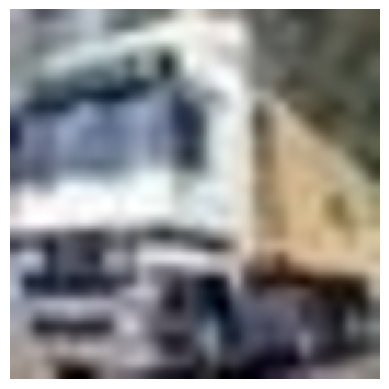

In [9]:
display_image(df.iloc[0]['image'])

#### 2. Test data

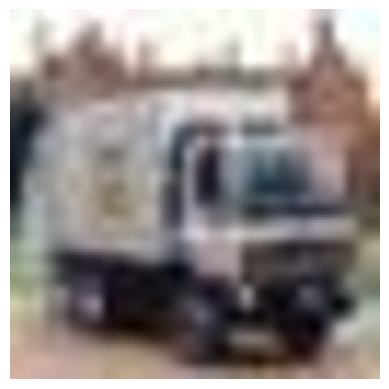

In [10]:
# First image in the test df
display_image(df_test.iloc[0]['image'])

### Data Cleaning: Handling Duplicates, Missing Data, and Corrupted Images

#### 1. Train data

In [11]:
def clean_image_data(df):
    # Hashing
    print("Removing duplicate images...")
    df['img_hash'] = df['image'].apply(lambda img: hashlib.md5(img.tobytes()).hexdigest())
    df.drop_duplicates(subset='img_hash', inplace=True)
    # Drop the hash column after removing duplicates
    df.drop(columns=['img_hash'], inplace=True)  

    # Check for missing labels
    print("Checking for missing labels...")
    missing_labels = df['label'].isnull().sum()
    if missing_labels > 0:
        print(f"Found {missing_labels} missing labels. Dropping rows with missing labels...")
        df.dropna(subset=['label'], inplace=True)

    # Verify images are loaded correctly and not corrupted
    print("Verifying image integrity...")
    valid_images = []
    for i, row in df.iterrows():
        try:
            img = Image.fromarray(row['image'])
            img.verify()  # Is image corrupted
            valid_images.append(True)
        except Exception as e:
            print(f"Corrupted image detected at index {i}: {e}")
            valid_images.append(False)
    
    df = df[valid_images]

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)
    
    return df


In [12]:
# Apply the cleaning function to train df
df_cleaned = clean_image_data(df)

# Display the cleaned train df
print("Cleaned DataFrame:")
print(df_cleaned.head())


Removing duplicate images...
Checking for missing labels...
Verifying image integrity...
Cleaned DataFrame:
                                               image  label
0  [[[174, 175, 185], [173, 173, 184], [169, 169,...      0
1  [[[167, 179, 191], [168, 180, 192], [168, 180,...      0
2  [[[152, 197, 104], [149, 195, 101], [143, 188,...      0
3  [[[131, 126, 122], [130, 125, 121], [128, 123,...      0
4  [[[37, 35, 11], [37, 35, 11], [37, 35, 11], [3...      0


#### 2. Test data

In [13]:
# Apply the cleaning function to test df
df_test_cleaned = clean_image_data(df_test)

# Display the cleaned test df
print("Cleaned DataFrame:")
print(df_test_cleaned.head())

Removing duplicate images...
Checking for missing labels...
Verifying image integrity...
Cleaned DataFrame:
                                               image  label
0  [[[240, 247, 239], [241, 248, 240], [242, 249,...      0
1  [[[190, 17, 0], [191, 18, 0], [193, 20, 0], [1...      0
2  [[[69, 94, 37], [70, 95, 38], [72, 97, 40], [7...      0
3  [[[167, 107, 46], [167, 107, 46], [167, 107, 4...      0
4  [[[27, 56, 96], [28, 57, 97], [29, 58, 98], [3...      0


### EDA

#### 1. Resize and Display Images

In [14]:
# Get sizes of all images
def get_image_sizes(image_list):
    sizes = [img.shape[:2] for img, _ in image_list]
    return sizes

In [15]:
sizes = get_image_sizes(all_images)
sizes_df = pd.DataFrame(sizes, columns=['Height', 'Width'])

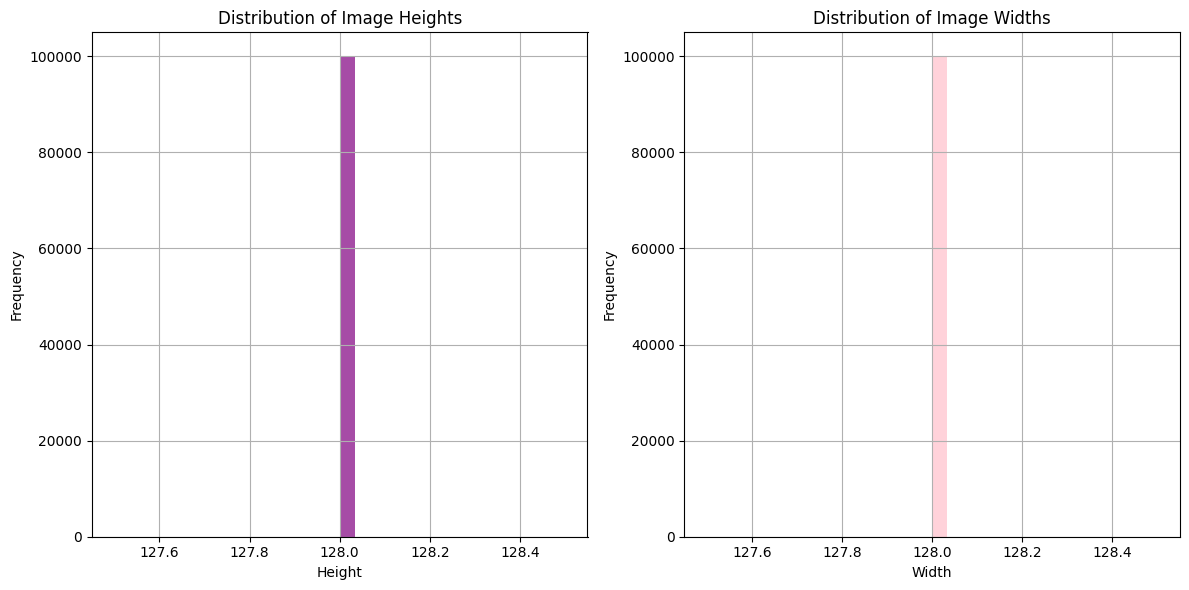

In [17]:
# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sizes_df['Height'].hist(bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sizes_df['Width'].hist(bins=30, color='pink', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

According the output above the image size is consistent.

#### 2. Check Class Balance

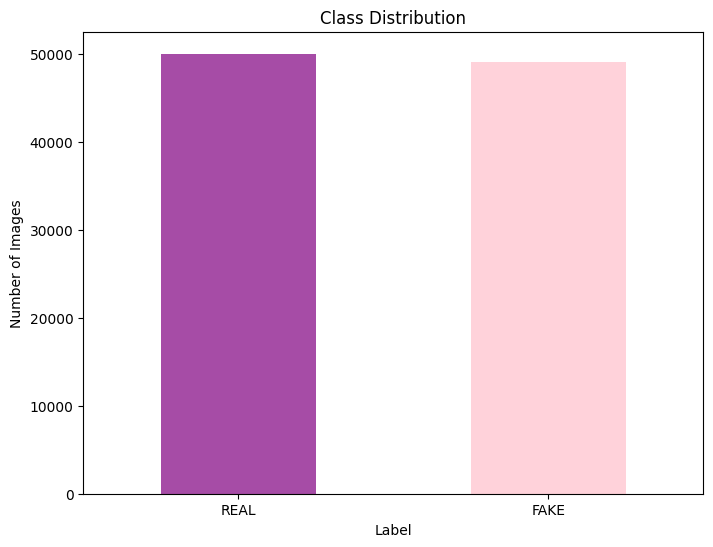

In [18]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['purple', 'pink'], alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['REAL', 'FAKE'], rotation=0)
plt.show()

#### 4. Image Aspect Ratio Distribution

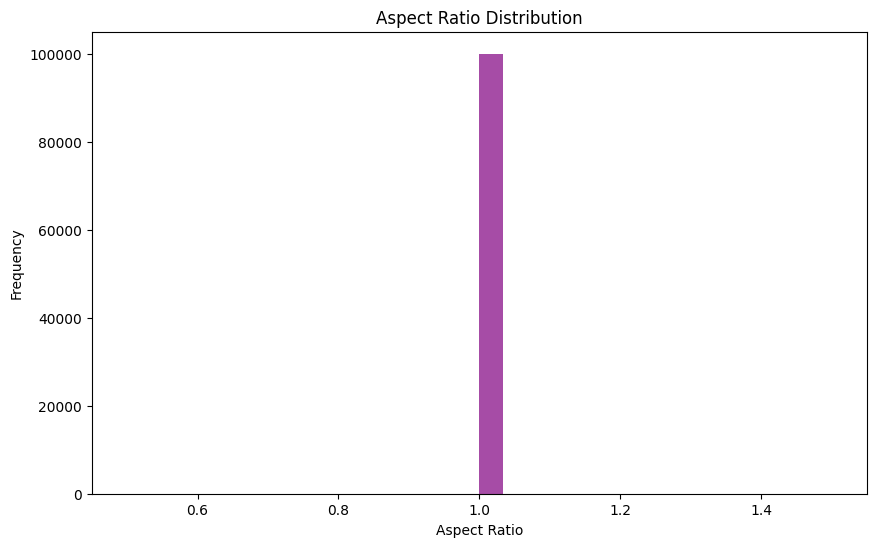

In [19]:
# Calculate aspect ratios
aspect_ratios = [img.shape[1] / img.shape[0] for img, _ in all_images]

plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

#### 5. Analyze Pixel Intensity Distribution

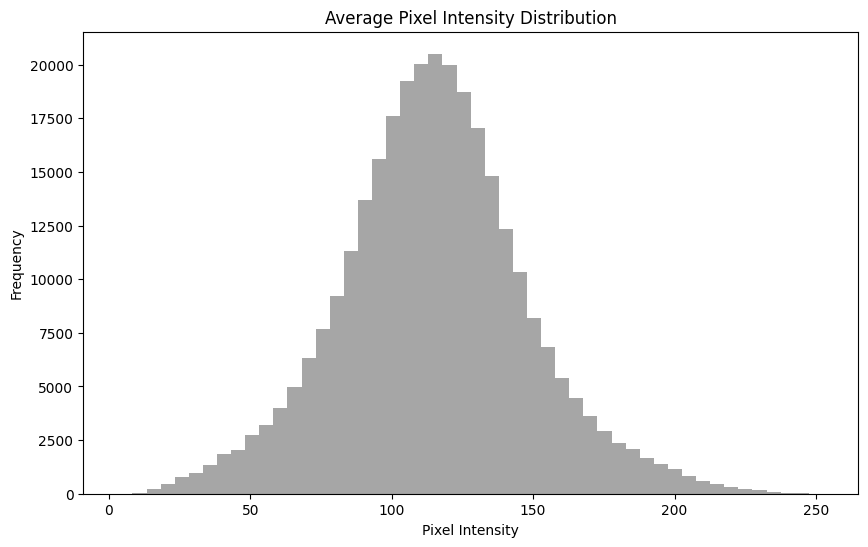

In [20]:
# Optimized function to compute pixel intensity distribution
def get_pixel_intensity_distribution(image_list):
    pixel_values = []
    for img, _ in image_list:
        pixel_values.append(img.mean(axis=(0, 1)))  # Calculate mean intensity for each image
    pixel_values = np.array(pixel_values).flatten()  # Flatten the list of means
    return pixel_values

# Compute and plot pixel intensity distribution
pixel_values = get_pixel_intensity_distribution(all_images)

plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
plt.title('Average Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### Modelling